In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import shutil
#import pandas
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error
import math


import tensorflow as tf

from tensorflow.keras import layers
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)



# Codificación por Posición#
## $PE_{(pos,2i)}=\sin(pos/10000^{2i/d_{model}})$<br/>$PE_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{model}})$ ##

In [2]:
def cogerAngulo(pos, i, d):
  ratiosAngulo = 1 / np.power(10000, (2 * (i//2)) / np.float32(d))
  return pos * ratiosAngulo

def codiciacionPosicional(posicion, d):
  angulos = cogerAngulo(np.arange(posicion)[:, np.newaxis], np.arange(d)[np.newaxis, :], d)
  
  angulos[:, 0::2] = np.sin(angulos[:, 0::2]) #Lo hacemos para los pares
  
  angulos[:, 1::2] = np.cos(angulos[:, 1::2]) #Lo hacemos para los impares
    
  posCodificados = angulos[np.newaxis, ...]
    
  return tf.cast(posCodificados, dtype=tf.float32)


## Mascaras ##
útiles para despreciar palabras que pueden afectar al comportamiento de la red

In [3]:
def crearMascaraEmpaquetada(secuencia):
    secuencia=tf.cast(tf.math.equal(secuencia,0), tf.float32)
    return secuencia[:, tf.newaxis, tf.newaxis, :]

def crearMascaraAlFrente(n): #Retorna una máscara diagonal de 0's en el triangulo inferior y de tamaño nxn
    mascara=1-tf.linalg.band_part(tf.ones((n,n)),-1,0)
    return mascara

# ATENCIÓN #
## $Atencion(Q,K,V)=softmax_k(\frac{QK^T}{(\sqrt{d_k})})V$ ##

In [4]:
#Este método calcula el producto escalar de matrices con la ecuación de Atención
def productoEscalarConAtencion(q,k,v, mascaraAtencion):
    matrizQK=tf.matmul(q,k,transpose_b=True)
    #Calculamos la profuncidad d
    dk=tf.cast(tf.shape(k)[-1],tf.float32)
    #Valor escalar de atención
    atencionEscalar=matrizQK/tf.math.sqrt(dk)

    #Sumamos la máscara de atención
    if(mascaraAtencion is not None):
        atencionEscalar+=(mascaraAtencion*-1e9) #el -1e9 es para generar un valor infinito.
    
    #Calculamos la función softmax y normalizamos al últmi eje
    pesosAtencion=tf.nn.softmax(atencionEscalar, axis=-1)

    salida=tf.matmul(pesosAtencion, v)

    return salida, pesosAtencion

In [5]:
class AtencionMultiple(tf.keras.layers.Layer):
  def __init__(self, d, numeroCabezas):
    super(AtencionMultiple, self).__init__()
    self.numeroCabezas = numeroCabezas
    self.d = d
    
    assert d % self.numeroCabezas == 0
    
    self.profundida = d // self.numeroCabezas #División entera
    
    self.wq = tf.keras.layers.Dense(d)
    self.wk = tf.keras.layers.Dense(d)
    self.wv = tf.keras.layers.Dense(d)
    
    self.capaDensa = tf.keras.layers.Dense(d)

  #  Divide la última dimensio dentro (numeroCabezas, profundidad) transponiendo el resultado
  # que tiene dimensioines (tamañoPaque, numeroCabezas, longitudSecuencia, profundidad)
  def dividirCabezas(self, x, tamañoPaquete):
    x = tf.reshape(x, (tamañoPaquete, -1, self.numeroCabezas, self.profundida))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mascara):
    tamañoPaquete = tf.shape(q)[0]
    
    q = self.wq(q)
    k = self.wk(k) 
    v = self.wv(v)
    
    q = self.dividirCabezas(q, tamañoPaquete)
    k = self.dividirCabezas(k, tamañoPaquete)
    v = self.dividirCabezas(v, tamañoPaquete)
    
    resultadoAtencion, pesosAtencion = productoEscalarConAtencion(q, k, v, mascara)
    
    resultadoAtencion = tf.transpose(resultadoAtencion, perm=[0, 2, 1, 3])

    concatenarAtenciones = tf.reshape(resultadoAtencion, (tamañoPaquete, -1, self.d))

    resultado = self.capaDensa(concatenarAtenciones)  
        
    return resultado, pesosAtencion

In [6]:
def redNeuronalHaciaDelante(d, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d)
  ])


In [7]:
class CapaCodificadora(tf.keras.layers.Layer):
  def __init__(self, d, numeroCabezas, dff, ratio=0.1):
    super(CapaCodificadora, self).__init__()

    self.mCA = AtencionMultiple(d, numeroCabezas)
    self.redFF = redNeuronalHaciaDelante(d, dff)

    self.capaNormal1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.capaNormal2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.despreciar1 = tf.keras.layers.Dropout(ratio) 
    self.despreciar2 = tf.keras.layers.Dropout(ratio)
    
  def call(self, x, entrenamiento, mascara):

    salidaAtencion, _ = self.mCA(x, x, x, mascara)
    salidaAtencion = self.despreciar1(salidaAtencion, training=entrenamiento)
    salida1 = self.capaNormal1(x + salidaAtencion)  
    
    salidaFFN = self.redFF(salida1)
    salidaFFN = self.despreciar2(salidaFFN, training=entrenamiento)
    salida2 = self.capaNormal2(salida1 + salidaFFN)  
    
    return salida2

In [8]:
class CapaDecodificadora(tf.keras.layers.Layer):
    def __init__(self, d, numeroCabeceras, dff, ratio=0.1):
        super(CapaDecodificadora, self).__init__()

        self.mCA1=AtencionMultiple(d, numeroCabeceras)
        self.mCA2=AtencionMultiple(d, numeroCabeceras)

        self.redFF=redNeuronalHaciaDelante(d,dff)

        self.capaNormal1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.capaNormal2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.capaNormal3=tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.despreciar1=tf.keras.layers.Dropout(ratio)
        self.despreciar2=tf.keras.layers.Dropout(ratio)
        self.despreciar3=tf.keras.layers.Dropout(ratio)

    def call(self,x,salidaCodificada, entrenamiento, mascaraAlFrente, mascaraEmpaquetada):
        atencion1, bloquePesosAtencion1 = self.mCA1(x,x,x,mascaraAlFrente)
        atencion1=self.despreciar1(atencion1,training=entrenamiento)
        salida1=self.capaNormal1(atencion1+x)
        #print(salida1)
        atencion2, bloquePesosAtencion2 = self.mCA2(salidaCodificada,salidaCodificada,salida1,mascaraEmpaquetada)
        atencion2=self.despreciar2(atencion2,training=entrenamiento)
        salida2=self.capaNormal2(atencion1+salida1)

        salidaRedFF=self.redFF(salida2)
        salidaRedFF=self.despreciar3(salidaRedFF, training=entrenamiento)
        salida3=self.capaNormal3(salidaRedFF+salida2)

        return salida3, bloquePesosAtencion1, bloquePesosAtencion2

In [9]:
class Codificador(tf.keras.layers.Layer):
    def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabulario, poisicionMaximaCodificacion, ratio=0.1):
        super(Codificador, self).__init__()

        self.d=d
        self.numeroCapas=numeroCapas

        self.embedding=tf.keras.layers.Embedding(tamañoVocabulario, d)
        self.posicionesCodificadas=codiciacionPosicional(poisicionMaximaCodificacion, self.d)

        self.capasCodificacion=[CapaCodificadora(self.d, numeroCabeceras,dff, ratio) for _ in range(self.numeroCapas)]

        self.despreciar=tf.keras.layers.Dropout(ratio)

    def call(self, x, entrenamiento, mascara):

        longitudSecuencia=tf.shape(x)[1]

        x=self.embedding(x)
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))
        x+=self.posicionesCodificadas[:, :longitudSecuencia, :]

        x=self.despreciar(x, training=entrenamiento)

        for i in range(self.numeroCapas):
            x=self.capasCodificacion[i](x,entrenamiento,mascara)

        return x

In [10]:
class Decodificador(tf.keras.layers.Layer):
    def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabulario, posicionMaximaCodificacion, ratio=0.1):
        super(Decodificador, self).__init__()

        self.d=d
        self.numeroCapas=numeroCapas

        self.embedding = tf.keras.layers.Embedding(tamañoVocabulario, d)
        self.posicionesCodificadas=codiciacionPosicional(posicionMaximaCodificacion, self.d)

        self.capasDecodificacion=[CapaDecodificadora(self.d, numeroCabeceras,dff, ratio) for _ in range(self.numeroCapas)]

        self.despreciar=tf.keras.layers.Dropout(ratio)

    def call(self, x, salidaCodificada, entrenamiento, mascaraAlFrente, mascaraEmpaquetada):

        longitudSecuencia=tf.shape(x)[1]
        pesosAtencion={}

        x=self.embedding(x)
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))
        x+=self.posicionesCodificadas[:, :longitudSecuencia, :]

        x=self.despreciar(x, training=entrenamiento)

        for i in range(self.numeroCapas):
            x, bloque1, bloque2 =self.capasDecodificacion[i](x,salidaCodificada,entrenamiento,mascaraAlFrente, mascaraEmpaquetada)

            pesosAtencion['capaDecodificadora{}_bloque1'.format(i+1)]=bloque1
            pesosAtencion['capaDecodificadora{}_bloque2'.format(i+1)]=bloque2

        return x, pesosAtencion


In [11]:
#ejemplo = CapaCodificadora(512, 8, 2048)

#salida = ejemplo(
#    tf.random.uniform((64, 43, 512)), False, None)
#print(salida.shape)
#ejemplo2 = CapaDecodificadora(512, 8, 2048)

#salida2,_,_ = ejemplo2(tf.random.uniform((64, 50, 512)), salida, False, None, None)

#salida2.shape

ejemplo=Codificador(2,512,8,2048,8500,10000)
entradaTemporal=tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
salida=ejemplo(entradaTemporal, False, None)
print(salida.shape)

ejemplo2=Decodificador(2,512,8,2048,8000,5000)
entradaTemporal=tf.random.uniform((64,26),dtype=tf.int64, minval=0, maxval=200)
salida2, atencion=ejemplo2(entradaTemporal, salida,False,None,None)

salida2.shape, atencion['capaDecodificadora2_bloque2'].shape



(64, 62, 512)


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [12]:
class Transformer(tf.keras.Model):
  def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabularioEntrada, 
               tamañoVocabularioSalida, posicionesEntrada, posicionesSalida, ratio=0.1):
    super(Transformer, self).__init__()

    self.codificador = Codificador(numeroCapas, d, numeroCabeceras, dff, 
                           tamañoVocabularioEntrada, posicionesEntrada, ratio)

    self.decodificador = Decodificador(numeroCapas, d, numeroCabeceras, dff, 
                           tamañoVocabularioSalida, posicionesSalida, ratio)

    self.capaFinal = tf.keras.layers.Dense(tamañoVocabularioSalida)
    
  def call(self, entrada, objetivo, entrenamiento, mascaraCodificadaEmpaquetada, 
           mascaraAlFrente, mascaraDecodificadaEmpaquetada):

    salidaCodificada = self.codificador(entrada, entrenamiento, mascaraCodificadaEmpaquetada)  
    
  
    salidaDecodificada, pesosAtencion = self.decodificador(
        objetivo, salidaCodificada, entrenamiento, mascaraAlFrente, mascaraDecodificadaEmpaquetada)
    
    salida = self.capaFinal(salidaDecodificada) 
    
    return salida, pesosAtencion

In [13]:
ejemplo = Transformer(2, 512, 8, 2048, 8500, 8000, 10000, 6000)

entradaTemporal = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
objetivoTemporal = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

salida, _ = ejemplo(entradaTemporal, objetivoTemporal, False, None, None, None)

salida.shape  # (batch_size, tar_seq_len, target_vocab_size)


TensorShape([64, 36, 8000])

# Hiperparámetros #

## Cargamos los elementos de converasción

In [14]:
def insertarPalabra(palabra, palabras, posiciones, minuscula, palabrasInvalidas=["\n"]):
    if len(palabra)==0 or palabra in palabrasInvalidas:
        return
    if minuscula:
        palabra=palabra.lower()
    if(palabra not in palabras):
        palabras.append(palabra)
    indice=palabras.index(palabra)
    posiciones.append(indice)
#Vocabulario obtiene tanto la lista de palabras como las posiciones por párrafo de cada palabra en el texto dado
#juntarParrafos tiene en cuenta que un \n que no está precedido por un "." o un ". " no se considera como parrafo nuevo
def vocabulario(linea, caracterSeparacion=' ', caracteresPuntuacion=['!','"','#','$','%','&','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\','\'',']','^','_','`','{','|','}','~','\t','\n','\r','¿','¡'], caracteresDescartados=['\r', '\t'], minuscula=True, palabras=['\n'], conParrafos=False, juntarParrafos=False, caracteresFinalesParrafo=['.','_']):
    posiciones=[]
    parrafo=[]
    esPuntuacion=False
    palabra=""
    ultimoCaracter=""
    palabrasInvalidas=caracteresDescartados
    for c in linea:
        if(c==caracterSeparacion):
            #if(esPuntuacion):
            #    palabra+=c
            insertarPalabra(palabra, palabras, parrafo, minuscula,palabrasInvalidas)
            palabra=""
            esPuntuacion=False
        else:
            if(c not in caracteresPuntuacion):
                if(esPuntuacion):
                    insertarPalabra(palabra, palabras, parrafo,minuscula,palabrasInvalidas)
                    esPuntuacion=False
                    palabra=c
                else:
                    palabra+=c
            else:
                insertarPalabra(palabra, palabras, parrafo,minuscula,palabrasInvalidas)
                palabra=""
                if c not in caracteresDescartados:
                    palabra=c
                    esPuntuacion=True
        if c!=caracterSeparacion and c not in caracteresDescartados and c!='\n':
            ultimoCaracter=c
    
    if conParrafos and len(parrafo)>0:
        if(not juntarParrafos or ultimoCaracter in caracteresFinalesParrafo):
            posiciones.append(parrafo)
            parrafo=[]
    #TODO Implementar un mecanismo para evitar palabras cortadas al final de línea con el -
    if palabra!="":
        insertarPalabra(palabra, palabras, parrafo,minuscula,palabrasInvalidas)
        palabra=""

    if(len(parrafo)>0):
        posiciones.append(parrafo)
        parrafo=[]
    return palabras,posiciones

In [15]:
def cogerDiccionario(diccionario,conversaciones):
    posicionesConversaciones=[]
    for conversacion in conversaciones:
        posicionesFrase=[]
        for frase in conversacion:
            diccionario,posiciones=vocabulario(frase.lower(),palabras=diccionario)
            posicionesFrase.append(posiciones)
        posicionesConversaciones.append(posicionesFrase)
    return diccionario,posicionesConversaciones

In [16]:
def normalizar(posiciones,longitud, tamaño):
    #datos=[[longitud]+posiciones+[longitud+1]+[0]*(tamaño-len(posiciones)-2)]
    datos=[posiciones+[0]*(tamaño-len(posiciones))]
    #datos=posiciones+([0]*(tamaño-len(posiciones)))
    #if(datos.shape[0]<tamaño):
    #datos.set_shape([None])
    return datos
#normalizar(posiciones[0][0][0],40)



In [17]:
#Genera una salida con frases texto - respuesta
def transformarConversacion(fichero):
    textoAEntrenar=""
    conversaciones=[]
    conversacion=[]
    with open(fichero,mode="r",encoding="utf8") as fichero:
        for linea in fichero:
            if(linea[0]=='-'):
                #Empezamos conversación
                if(len(conversacion)>0):
                    conversaciones.append(conversacion.copy())
                    conversacion.clear()
                linea=linea[1:]
            frase=linea.strip()
            if(len(frase)==0):
                continue
            if(frase[0]=='-'):
                frase=frase[1:].strip()
                conversacion.append(frase.strip('"'))
            else:
                conversacion[len(conversacion)-1]+=" "+frase.strip()
    if(len(conversacion)>0):
        conversaciones.append(conversacion.copy())
    return conversaciones

In [18]:
ficheros=["textos/dialogo.txt"]
diccionario=['\n']
for fichero in ficheros:
    conversaciones=transformarConversacion(fichero)
    diccionario,posiciones=cogerDiccionario(diccionario,conversaciones)
    print(conversaciones[0],posiciones[0])
    print(len(diccionario),diccionario[0])

tamañoVocabularioEntrada = len(diccionario) + 2
tamañoVocabularioSalida = len(diccionario) + 2

['Buenos días, ¿cómo estás?', 'Estoy bien, ¿y tú?', 'Yo también estoy bien.', 'Que bueno.', 'Así, es.'] [[[1, 2, 3, 4, 5, 6, 7]], [[8, 9, 3, 4, 10, 11, 7]], [[12, 13, 8, 9, 14]], [[15, 16, 14]], [[17, 3, 18, 14]]]
1657 



In [19]:
datosEntrenamiento=[]
for conversacion in posiciones:
    if(len(conversacion)>1):
        for i in range(len(conversacion)-1):
            datosEntrenamiento.append([tf.constant(normalizar(conversacion[i][0],tamañoVocabularioEntrada-2,48),tf.int64),tf.constant(normalizar(conversacion[i+1][0],tamañoVocabularioEntrada-2,48),tf.int64)])

print(datosEntrenamiento[0])

[<tf.Tensor: shape=(1, 48), dtype=int64, numpy=
array([[1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]], dtype=int64)>, <tf.Tensor: shape=(1, 48), dtype=int64, numpy=
array([[ 8,  9,  3,  4, 10, 11,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)>]


In [20]:
EPOCAS=20



In [71]:
condicionesEntrenamiento = [
    tf.TensorSpec(shape=(48, None), dtype=tf.int64),
    tf.TensorSpec(shape=(48, None), dtype=tf.int64),
]
#@tf.function(input_signature=condicionesEntrenamiento)
def pasoEntrenamiento(entrada, objetivo):
  #entradaObjetivo = objetivo[:, :-1]
  #objetivoReal = objetivo[:, 1:]
  entradaObjetivo = objetivo
  objetivoReal = objetivo
  
  mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada = crearMascara(entrada,entradaObjetivo)
  #print(mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada)
  
  with tf.GradientTape() as cadenaEntrada:
    cadenaEntrada.watch(transformador.trainable_variables)
    prediccion, _ = transformador(entrada, entradaObjetivo, 
                                 True, 
                                 mascaraCodificadaEmpaquetada, 
                                 mascaraCombinada, 
                                 mascaraDecodificadaEmpaquetada)
    perdidas = funcionPerdida(objetivoReal, prediccion)
  #print(transformador.trainable_variables)
  gradiente = cadenaEntrada.gradient(perdidas, transformador.trainable_variables)  
  #print(list(zip(gradiente, transformador.trainable_variables))[1])  
  optimizador.apply_gradients(zip(gradiente, transformador.trainable_variables))
  
  entrenamientoPerdidos(perdidas)
  entrenamientoPrecision(objetivoReal,prediccion)

In [74]:
import warnings
warnings.filterwarnings('ignore')
pasoEntrenamiento(datosEntrenamiento[0][0], datosEntrenamiento[0][1])


AssertionError: invalid action: 'warning'

## Generar datos de entrenamiento ##

In [22]:
numeroCapas = 4 #6
d = 128 #512
dff = 512 #2048
numeroCabeceras = 8
tamañoVocabularioEntrada = len(diccionario) + 2
tamañoVocabularioSalida = len(diccionario) + 2
ratioDespreciar = 0.1


# Optimizador #
## $lrate=d^{-0.5}_{model}*\min(step\_num^{-0.5},step\_num*warmup\_steps^{-1.5})$ ##

In [23]:
class ProgramarOptimizacion(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d, pasosWarmup=4000):
    super(ProgramarOptimizacion, self).__init__()
    
    self.d = d
    self.d = tf.cast(self.d, tf.float32)

    self.pasosWarmup = pasosWarmup
    
  def __call__(self, paso):
    argumento1 = tf.math.rsqrt(paso)
    argumento2 = paso * (self.pasosWarmup ** -1.5)
    
    return tf.math.rsqrt(self.d) * tf.math.minimum(argumento1, argumento2)


Text(0.5, 0, 'Train Step')

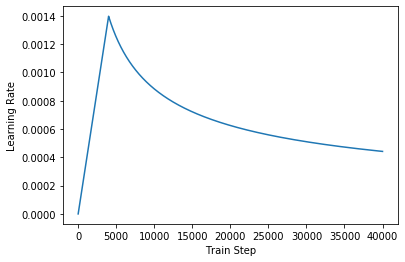

In [24]:
ratioAprendizaje=ProgramarOptimizacion(d)
optimizador=tf.keras.optimizers.Adam(ratioAprendizaje, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

ratioAprendizajeProgramadoTemporal=ProgramarOptimizacion(d)

plt.plot(ratioAprendizajeProgramadoTemporal(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#Text(0.5, 0, 'Train Step')

In [25]:
objetoPerdido = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def funcionPerdida(real, predicho):
  mascara = tf.math.logical_not(tf.math.equal(real, 0))
  perdido = objetoPerdido(real, predicho)

  mascara = tf.cast(mascara, dtype=perdido.dtype)
  perdido *= mascara
  
  return tf.reduce_mean(perdido)


In [26]:
entrenamientoPerdidos = tf.keras.metrics.Mean(name='entrenamientoPerdidos')
entrenamientoPrecision = tf.keras.metrics.SparseCategoricalAccuracy(name='entrenamientoPrecision')


# Entrenamiento y puntos de control #

In [27]:
transformador = Transformer(numeroCapas, d, numeroCabeceras, dff,
                          tamañoVocabularioEntrada, tamañoVocabularioSalida, 
                          tamañoVocabularioEntrada, tamañoVocabularioSalida,
                          ratioDespreciar)


In [28]:
def crearMascara(entrada, objetivo):
  # Encoder padding mask
  mascaraCodificadaEmpaquetada = crearMascaraEmpaquetada(entrada)
  mascaraDecodificadaEmpaquetada = crearMascaraEmpaquetada(entrada)
  mascaraAlFrente = crearMascaraAlFrente(tf.shape(objetivo)[1])
  mascaraDecodificadaEmpaqutadaObjetivo = crearMascaraEmpaquetada(entrada)
  
  mascarasCombinadas = tf.maximum(mascaraDecodificadaEmpaqutadaObjetivo, mascaraAlFrente)
  return mascaraCodificadaEmpaquetada, mascarasCombinadas, mascaraDecodificadaEmpaquetada

In [29]:
print(datosEntrenamiento[0][0])
#entradaObjetivo = datosEntrenamiento[0][1][:, :-1]
entradaObjetivo = datosEntrenamiento[0][1]
print(entradaObjetivo)
#objetivoReal = datosEntrenamiento[0][1][:, 1:]
objetivoReal = datosEntrenamiento[0][1]
print(objetivoReal)
mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada = crearMascara(datosEntrenamiento[0][0],entradaObjetivo)
print(mascaraCodificadaEmpaquetada)
print(mascaraCombinada)
print(mascaraDecodificadaEmpaquetada)
prediccion, _ = transformador(datosEntrenamiento[0][0], entradaObjetivo, 
                                 True, 
                                 mascaraCodificadaEmpaquetada, 
                                 mascaraCombinada, 
                                 mascaraDecodificadaEmpaquetada)
#pasoEntrenamiento(datosEntrenamiento[0][0], datosEntrenamiento[0][1])
#datosEntrenamiento[0][0]

tf.Tensor(
[[1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 48), dtype=int64)
tf.Tensor(
[[ 8  9  3  4 10 11  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(1, 48), dtype=int64)
tf.Tensor(
[[ 8  9  3  4 10 11  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(1, 48), dtype=int64)
tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1.]]]], shape=(1, 1, 1, 48), dtype=float32)
tf.Tensor(
[[[[0. 1. 1. ... 1. 1. 1.]
   [0. 0. 1. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   ...
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]]]], shape=(1, 1, 48, 48), dtype=float32)
tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1

In [30]:
ficheroPuntoControl="./modelos/seq2seq"
puntoControl=tf.train.Checkpoint(transformer=transformador, optimizer=optimizador)

manejarPuntoControl=tf.train.CheckpointManager(puntoControl, ficheroPuntoControl, max_to_keep=5)

if manejarPuntoControl.latest_checkpoint:
  puntoControl.restore(manejarPuntoControl.latest_checkpoint)
  print ('Restauramos el último punto de control')


## Entrenar ##

In [31]:
EPOCAS=1
for epoca in range(EPOCAS):
  tiempoInicial = time.time()
  
  entrenamientoPerdidos.reset_states()
  entrenamientoPrecision.reset_states()
  for (i, datos) in enumerate(datosEntrenamiento):
    pasoEntrenamiento(datos[0], datos[1])
    if i % 50 == 0:
      print ('Epoca {} Lote {} Perdida {:.4f} Precisión {:.4f}'.format(
          epoca + 1, i, entrenamientoPerdidos.result(), entrenamientoPrecision.result()))
      
  if (epoca + 1) % 5 == 0:
    puntoControlGuardado = manejarPuntoControl.save()
    print ('Salvando punto de control en la epoca {} a {}'.format(epoca+1,
                                                         puntoControlGuardado))
    
  print ('Epoca {} Perdida {:.4f} Precisión {:.4f}'.format(epoca + 1, 
                                                entrenamientoPerdidos.result(), entrenamientoPrecision.result()))

  print ('Tiempo que tomo desde la primera cada epoca: {} secs\n'.format(time.time() - tiempoInicial))


ansformer_1/decodificador_2/capa_decodificadora_4/atencion_multiple_17/dense_95/kernel:0', 'transformer_1/decodificador_2/capa_decodificadora_4/atencion_multiple_17/dense_95/bias:0', 'transformer_1/decodificador_2/capa_decodificadora_4/atencion_multiple_17/dense_96/kernel:0', 'transformer_1/decodificador_2/capa_decodificadora_4/atencion_multiple_17/dense_96/bias:0', 'transformer_1/decodificador_2/capa_decodificadora_5/atencion_multiple_19/dense_103/kernel:0', 'transformer_1/decodificador_2/capa_decodificadora_5/atencion_multiple_19/dense_103/bias:0', 'transformer_1/decodificador_2/capa_decodificadora_5/atencion_multiple_19/dense_104/kernel:0', 'transformer_1/decodificador_2/capa_decodificadora_5/atencion_multiple_19/dense_104/bias:0', 'transformer_1/decodificador_2/capa_decodificadora_5/atencion_multiple_19/dense_105/kernel:0', 'transformer_1/decodificador_2/capa_decodificadora_5/atencion_multiple_19/dense_105/bias:0', 'transformer_1/decodificador_2/capa_decodificadora_5/atencion_multi

In [79]:
import tensorflow_datasets as tfds
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']


tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_en


<SubwordTextEncoder vocab_size=8087>

In [80]:
tokenizer_en

<SubwordTextEncoder vocab_size=8087>

In [81]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)

In [90]:
#for ts in tokenized_string:
#    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

def enc(l):
    l = [tokenizer_en.vocab_size] + tokenizer_en.encode(l) + [tokenizer_en.vocab_size+1]
    return l
def tf_enc(l):
    resultado_l=tf.py_function(enc,[en], [tf.int64])
    resultado_l.set_shape([NONE])
    return resultado_l
train_examples.map(tf_enc)

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


TypeError: in converted code:


    TypeError: tf__tf_enc() takes 1 positional argument but 2 were given


In [54]:
for i,dato in enumerate(train_examples):
    if(i==0):
        print(dato)


(<tf.Tensor: shape=(), dtype=string, numpy=b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'>)


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'map'